(gen-ref)=
# Referenzdatensatz generieren

## Lernziele

<div class="admonition note" style="background: #e5f1ff; padding: 10px">
<div class="title"><b>LERNZIELE</b></div>
    <ul>
        <li> Referenzdaten generieren </li>
        <li> mithilfe von Annahmen und bestehenden Datensätzen </li>
        <li> um den Istzustand zu analysieren und Veränderungen zu vergleichen </li>
    </ul>
</div>

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import locale
from distutils.spawn import find_executable

print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('os', os)
print('locale', locale)

Versionen der verwendeten python-Module: 
numpy 1.21.5
matplotlib 3.5.2
pandas 1.4.4
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/datetime.py'>
os <module 'os' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/os.py'>
locale <module 'locale' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/locale.py'>


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
locale.setlocale(locale.LC_ALL, '')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

### Funktionen definieren

In [3]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header = 7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [VA]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Iterate through dataframe and reformat data
    for index, row in df.iterrows():
        
        # Reformat other columns
        for column in df.columns:
            if not column == "timestamp":
                
                # Get string from cell
                string = row[column].replace(",", ".")

                # Create float from string
                value = float(string)
                
                # Set reformated cell
                row[column] = value

    # Cast data types to float 64
    for column in df.columns:
        if not column == "timestamp":
            df = df.astype({column: 'float64'})
            
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [4]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header = 7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [VA]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Iterate through dataframe and reformat data
    for index, row in df.iterrows():
        
        # Reformat other columns
        for column in df.columns:
            if not column == "timestamp":
                
                # Get string from cell
                string = row[column].replace(",", ".")

                # Create float from string
                value = float(string)
                
                # Set reformated cell
                row[column] = value

    # Cast data types to float 64
    for column in df.columns:
        if not column == "timestamp":
            df = df.astype({column: 'float64'})
            
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [5]:
def map_timestamp(df, start_timestamp_string, resolution = 1, column_name = "timestamp"):
    
    # Create datetime object from start timestamp
    start_timestamp = dt.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")
    
    timestamps = []
    
    # Iterate through data frame rows
    for idx, row in df.iterrows():
        
        # Create mapped timestamp
        mapped_timestamp = start_timestamp + dt.timedelta(minutes = len(timestamps) * resolution)
        
        # Append timestamp
        timestamps.append(mapped_timestamp)
        
    
    df[column_name] = timestamps
    
    
    # Return mapped data frame
    return df

In [6]:
def create_uniform_dataframe(size, value):
    values = []
    
    for i in range(0, size):
        values.append(value)
    
    timestamps = ["01-01-2019 00:00:00" for x in range(size)]

    df = pd.DataFrame()
    
    df["timestamp"] = timestamps
    df["Current [A]"] = values
    df["Active Power [W]"] = values
    df["Apparent Power [VA]"] = values

    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [7]:
def concat_data(dfs):
    
    # dfs in tuple-format: (dataFrame, startTimestamp)
    
    # Prepare data frames
    dfsToConcat = []
    
    # Set timestamps
    for df in dfs:
        mapped_df = map_timestamp(df[0], df[1])
        dfsToConcat.append(mapped_df.copy())
        
    return pd.concat(dfsToConcat)

In [8]:
def timestamp_based_concat(df, start_timestamp_string, number_of_concats, offset):
    result = []
    
    # Create datetime object from start timestamp
    start_timestamp = dt.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")

    for i in range(0, number_of_concats):
        
        timestamp = start_timestamp + dt.timedelta(minutes = offset * i)
        timestamp_string = timestamp.strftime("%d-%m-%Y %H:%M:%S")
        
        result.append((df.copy(), timestamp_string))
        
    return result

## Referenzdatensatz definieren

Das Beispiel hier ist sehr einfach gehalten. Es soll hier um die Vorgehensweise gehen. Zwei Beispielgeräte mit definiertem Verhalten bestimmen den Datensatz

### Beispielbeschreibung

Das Beispielgerät hat im Betrieb das gemessene Lastprofil in der Datei `../data/Energieloggertestdaten.csv`. [SYE-data](http://oer4renewables.gitlab.io/systemtechnik-fuer-energieeffizienz/04/SYE-data.html) beschreibt das Einlesen der Daten.

In [9]:
examplemeas = read_energy_logger_file('../data/Energieloggertestdaten.csv')

### Standbyverbrauch im Beispiel

Aus dem Beispieldatenblatt geht ein Standbyverbrauch von 0,2 Watt hervor, der sich mit dem Energielogger nicht zuverlässig messen lässt.

In [10]:
examplestandby = .2 # Watt
examplestandbydf = create_uniform_dataframe(1,examplestandby)

### Nutzungszeiten im Beispiel

Das Gerät wird um 09:00 und um 11:30 Uhr vom 01.04.2020 für einige Tage vom Beispielnutzer eingesetzt. Die ganze Zeit ist Standbyleistung nötig.

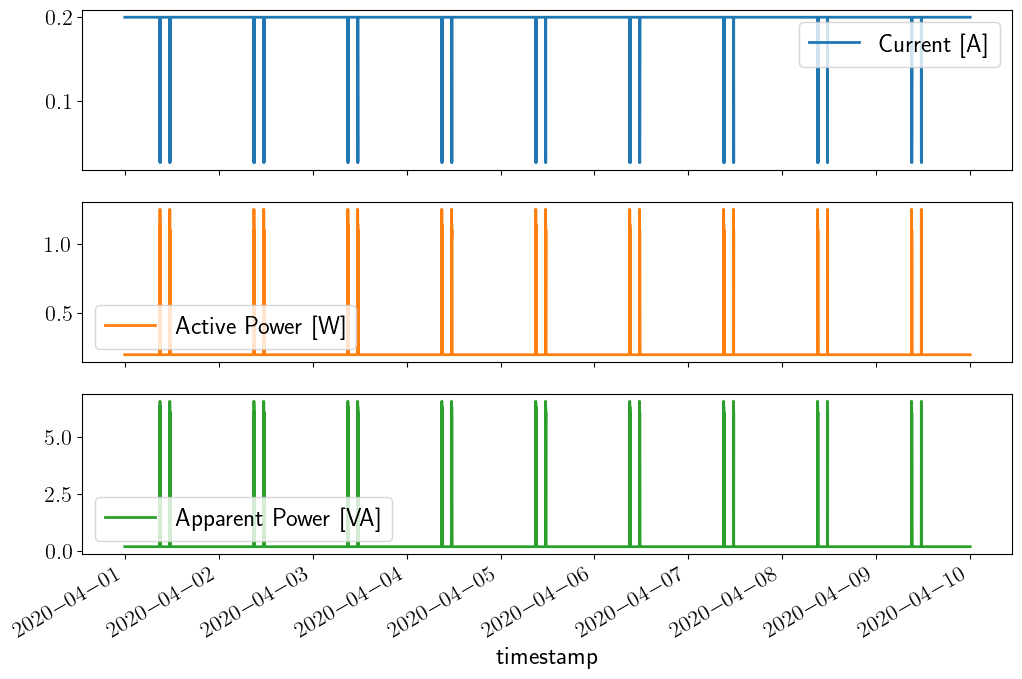

In [11]:
no_days = 10 # number of days
start_date = dt.datetime.strptime("01-04-2020 00:00:00", "%d-%m-%Y %H:%M:%S")
duration = 24*60*(no_days-1) # minutes in a day during no_days
exampledata = timestamp_based_concat(examplestandbydf, start_date.strftime("%d-%m-%Y %H:%M:%S"), duration, 1)
for x in range(no_days-1): 
    tmp_date = start_date + dt.timedelta(days = x, hours = 9)
    tmp_date2 = start_date + dt.timedelta(days = x, hours = 11.5)
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date2.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
exampledatadf = concat_data(exampledata)
exampledatadf = exampledatadf.set_index('timestamp')
exampledatadf.plot(subplots=True, figsize=(12,8))
plt.show()

### Zeitliche Varianz einbauen

Es ist reichlich unwahrscheinlich, dass ein Gerät immer um Punkt 9 Uhr und um Punkt 11:30 angeschaltet wird und dies an allen Tagen des Jahres. Das bedeutet, dass man für die Startzeit noch eine Varianz hinterlegen sollte:

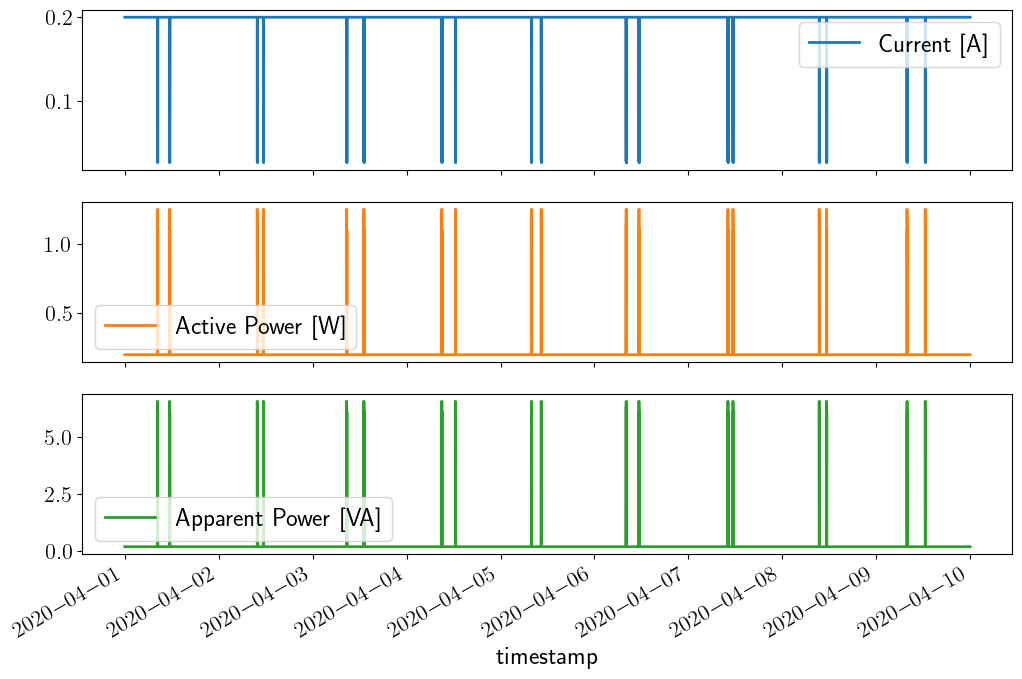

In [12]:
no_days = 10 # number of days
start_date = dt.datetime.strptime("01-04-2020 00:00:00", "%d-%m-%Y %H:%M:%S")
duration = 24*60*(no_days-1) # minutes in a day during no_days
exampledata = timestamp_based_concat(examplestandbydf, start_date.strftime("%d-%m-%Y %H:%M:%S"), duration, 1)
for x in range(no_days-1): 
    tmp_date = start_date + dt.timedelta(days = x, hours = 9+np.random.randn(1)[0])
    tmp_date2 = start_date + dt.timedelta(days = x, hours = 11.5+np.random.randn(1)[0])
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date2.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
exampledatadf = concat_data(exampledata)
exampledatadf = exampledatadf.set_index('timestamp')
exampledatadf.plot(subplots=True, figsize=(12,8))
plt.show()

Diese Varianz lässt sich noch vergrößern oder verkleinern, indem man vor den Befehl `np.random.randn(1)[0]` einen Faktor setzt und diesen aufmultipliziert - oder indem man `minutes = np.random.randn(1)[0]` setzt.

Außerdem ist für längere Lastprofile z. B. noch wichtig, Urlaubszeiten, jahreszeitliche Schwankungen etc. zu hinterlegen.

### Referenzdatensatz enthält weiteres Beispielgerät

Die Daten für das nächste Beispielgerät erzeugt man auf ähnliche Weise und addiert dann beide DataFrames. Für das Beispiel wird diese Addition einfach mit demselben DataFrame durchgeführt:

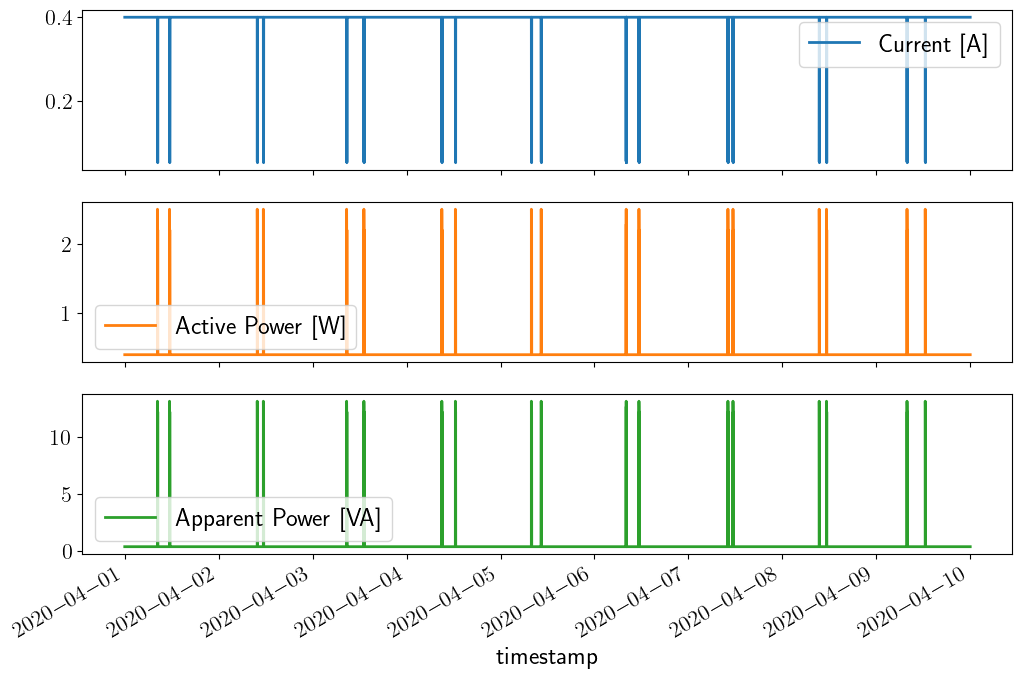

In [13]:
exampledatadf = exampledatadf + exampledatadf
exampledatadf.plot(subplots=True, figsize=(12,8))
plt.show()

## Mathematische Möglichkeiten zur Ergänzung von Datensätzen

Ein Lastprofil ist ein Zeitreihenmodell {cite:p}`schellong_modellierung_2000`.

Es existiert kein zwingender, expliziter, kausaler Zusammenhang zwischen Einflussgrößen und Energiebedarf. Beispielsweise benötigen verschiedene Vier-Personen-Haushalte unterschiedlich viel elektrische Energie. Daher ist immer eine Plausibilisierung nötig, wenn man mathematisch modelliert.

**Saisonale Variation** $S(t)$: Hier beschreibt man z. B. mit einem temperatur- oder lichtabhängigen Faktor, dass sich bestimmte Bedarfe erhöhen oder verringern.

**Trends** $T(t)$ erhält man, indem man Mittelwerte über größere Zeiträume bildet und so z. B. herausfindet, ob der Energiebedarf für bestimmte Aktivitäten/Prozesse oder auch für alles zusammen im Betrachtungszeitraum gestiegen oder gesunken ist. Modelliert man einen Trend, so legt man, ähnlich wie bei der Modellierung der saisonalen Variation einen entsprechenden Faktor an, mit dem bestimmte oder alle Bedarfe erhöht oder verringert werden.

**Überjährige zyklische Komponenten** $C(t)$ sind z. B. Effekte wie Urlaub oder Weihnachtsferien, die immer wieder auftreten, zyklisch sich wiederholen, aber auch z. B. die Unterscheidung zwischen Wochenende und Wochentag.

**Ausreißer** $R(t)$ treten häufig bei singulären Ereignissen auf, z. B. sinkt der Energiebedarf in bestimmten Produktionsbetrieben während der Fußballweltmeisterschaft-Endspiele (und erhöht sich dafür in Haushalten).

Die beschriebenen Komponenten lassen sich addieren für ein **additives Zeitreihenmodell**: 
\begin{equation}
y(t) = T(t) + S(t) + C(t) + R(t)
\end{equation}

Alternativ lassen sich **hybride Zeitreihenmodelle** nutzen:
\begin{equation}
y(t) = T(t)\cdot S(t) + R(t)
\end{equation}

Es ist nicht eins der Modelle besser oder schlechter als das andere, sondern es hängt davon ab, was Sie modellieren wollen und dann eignen sich die verschiedenen Modelle unterschiedlich gut.

```{bibliography}
:filter: docname in docnames
```